# Toy example of coffee shop world


This is a toy example of the type of data we will have from coffee shop world. Coffeeshop world outputs symbolic sentences, but as of right now, these still need to be hand processed to create embeddings. 

Here, we create two example events (a poetry reading and a fight) that we will alternate for the SEM model. The strings below represents a raw output of a structured coffee shop world story. We will create two sequences of strings from them, representing each event

In [1]:
poetry_raw = 'BEGIN(Mariko); Sit_down(Mariko,Sarah); Emcee_intro(Olivia,Julian); Poet_performs(Julian); Subject_performs(Mariko,Sarah); Say_goodbye(Mariko,Sarah); END(Mariko). '

In [2]:
fight_raw = 'BEGIN(Silvia); Walk_to_front(Silvia,Nick); Step_in_front(Nick,Silvia); Ignore(Silvia,Nick,coffee); X_stare(Nick,Silvia); Dessert_crumble(Silvia,muffin,Nick); Call_policeman(Pradeep,Silvia); Hate_coffee(Silvia,Nick); END(Nick,Ben).'

First, we parse the poetry reading into a list of role/filler binding pairs:

In [3]:
roles = [('verb'), ('agent'), ('patient')]

# parse the string for sentences, split at ;
poetry_symb = poetry_raw.split('; ')
for ii, s in enumerate(poetry_symb):
    # split the string and remove the structure markers
    s = s.replace('(', " ").replace(')', ' ').replace(',', ' ').replace('.','').split()
    
    # attach the role bindinds
    s = [(s[jj], roles[jj]) for jj in range(len(s))]
    poetry_symb[ii] = s    

print poetry_symb

[[('BEGIN', 'verb'), ('Mariko', 'agent')], [('Sit_down', 'verb'), ('Mariko', 'agent'), ('Sarah', 'patient')], [('Emcee_intro', 'verb'), ('Olivia', 'agent'), ('Julian', 'patient')], [('Poet_performs', 'verb'), ('Julian', 'agent')], [('Subject_performs', 'verb'), ('Mariko', 'agent'), ('Sarah', 'patient')], [('Say_goodbye', 'verb'), ('Mariko', 'agent'), ('Sarah', 'patient')], [('END', 'verb'), ('Mariko', 'agent')]]


We repeate the same for the fight event (this requires a little custom code):

In [4]:

roles = [('verb'), ('agent'), ('patient')]

# parse the string for sentences, split at ;
fight_symb = fight_raw.split('; ')
for ii, s in enumerate(fight_symb):
    # split the string and remove the structure markers
    s = s.replace('(', " ").replace(')', ' ').replace(',', ' ').replace('.','').split()
    
    # attach the role bindinds
    # break the ignore sentence into two
    if s[0] == 'Ignore':
        s = [[(s[0], 'verb'), (s[1], 'agent'), (s[2], 'patient')], 
             [('Order_drink', 'verb'), (s[1], 'agent'), (s[3], 'patient')]]
    elif s[0] == 'Dessert_crumble':
        s = [(s[0], 'verb'), (s[1], 'agent'), (s[2], 'instrument'), (s[3], 'patient')]
    else:
        s = [(s[jj], roles[jj]) for jj in range(len(s))]
        
    fight_symb[ii] = s    
    
_fight_symb = []
for f in fight_symb:
    if type(f[0]) == list:
        for f0 in f:
            _fight_symb.append(f0)
    else:
        _fight_symb.append(f)
fight_symb = _fight_symb

print fight_symb

[[('BEGIN', 'verb'), ('Silvia', 'agent')], [('Walk_to_front', 'verb'), ('Silvia', 'agent'), ('Nick', 'patient')], [('Step_in_front', 'verb'), ('Nick', 'agent'), ('Silvia', 'patient')], [('Ignore', 'verb'), ('Silvia', 'agent'), ('Nick', 'patient')], [('Order_drink', 'verb'), ('Silvia', 'agent'), ('coffee', 'patient')], [('X_stare', 'verb'), ('Nick', 'agent'), ('Silvia', 'patient')], [('Dessert_crumble', 'verb'), ('Silvia', 'agent'), ('muffin', 'instrument'), ('Nick', 'patient')], [('Call_policeman', 'verb'), ('Pradeep', 'agent'), ('Silvia', 'patient')], [('Hate_coffee', 'verb'), ('Silvia', 'agent'), ('Nick', 'patient')], [('END', 'verb'), ('Nick', 'agent'), ('Ben', 'patient')]]


In this toy example, these two events are very different and have very, very little overlap between them. This is ideal for a toy demonstration (at least a first one).

In [5]:
# what is the intersection of filler words between the two events?
set([b[0] for s in poetry_symb for b in s]).intersection([b[0] for s in fight_symb for b in s])

{'BEGIN', 'END'}

Before we embed these into vectors, we need a library of fillers and roles

In [6]:
role_library = set([b[1] for s in fight_symb for b in s] + [b[1] for s in poetry_symb for b in s])
filler_library = set([b[0] for s in fight_symb for b in s] + [b[0] for s in poetry_symb for b in s])


print role_library
print filler_library

from opt import plate_formula, embed, encode, decode, embed_onehot

# figure out how many dimensions we need
n = len(role_library) + len(filler_library);     # vocabulary size
k = 8;      # maximum number of terms to be combined
err = 0.01; # error probability
d = plate_formula(n, k, err);

# create a library of vectors
role_dict = {r: embed(1, d) for r in role_library}
filler_dict = {f: embed_onehot(1, d) for f in filler_library}

set(['instrument', 'verb', 'patient', 'agent'])
set(['Sarah', 'Call_policeman', 'muffin', 'Silvia', 'Pradeep', 'Nick', 'Ben', 'BEGIN', 'Subject_performs', 'Olivia', 'Say_goodbye', 'Emcee_intro', 'Sit_down', 'Dessert_crumble', 'Order_drink', 'Hate_coffee', 'coffee', 'END', 'Poet_performs', 'Ignore', 'Walk_to_front', 'Julian', 'Step_in_front', 'X_stare', 'Mariko'])


For this version, as a test, we are not going to use role/filler bindings. This is because the convolution opperation alters the vector space, making models harder to train. That is, if we pick guassian random unit vectors as our embedding space, the product of the convolution is does not have a mean of 0 and std of 1.

In [7]:
import numpy as np

r = role_dict[role_dict.keys()[0]]
print "Role    mean = %.2f, std = %.2f" % (np.mean(r), np.std(r))
f = filler_dict[filler_dict.keys()[0]]
print "Filler  mean = %.2f, std = %.2f" % (np.mean(f), np.std(f))

e = encode(f, r)
print "Encoded mean = %.2f, std = %.2f" % (np.mean(e), np.std(e))

Role    mean = -0.00, std = 1.00
Filler  mean = 0.00, std = 0.05
Encoded mean = -0.00, std = 0.05


As we can see, using circular convolution to encode the role filler binding blows out the variance. This will make training difficult, and requires more investigation on our part before we are ready to go ahead (at least, nothing tried has worked so far). Specifically, we don't know how to best normalize these vectors for machine learnign without distroying the structure.

In [8]:
import numpy as np

# create the structured representation of the sentences for each event
def embed_event(event_symb):
    event_embedded = []
    for s in event_symb:
        X0 = np.zeros((1, d))
        for filler, role in s:
            X0 += encode(role_dict[role], filler_dict[filler]) + filler_dict[filler]
        event_embedded.append(X0)
    return np.concatenate(event_embedded)

poetry_embedded = embed_event(poetry_symb)
fight_embedded = embed_event(fight_symb)

Concatenate to create the sequence of events [Poetry, Fight, Poetry, Fight]:

In [9]:
# okay! create the events for segmentation
n_p = poetry_embedded.shape[0]
n_t = fight_embedded.shape[0]
X_train = np.concatenate([poetry_embedded, fight_embedded, poetry_embedded, fight_embedded])
y_train = np.concatenate([np.zeros(n_p), np.ones(n_t), np.zeros(n_p), np.ones(n_t)])
print X_train.shape, y_train.shape

(34, 421) (34,)


# Segmentation

In [10]:
# scaling tends to improve segmentation
N, D  = X_train.shape
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

X_train = scale(X_train)
distances = [np.linalg.norm(X_train[ii, :] - X_train[ii+1, :]) for ii in range(N-1)]

In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
from models import SEM, KerasSimpleRNN, KerasGRU
from opt.utils import evaluate
import numpy as np
from sklearn.preprocessing import scale

# scaling tends to improve segmentation
X_train = scale(X_train)

Using TensorFlow backend.


In [12]:
# set the parameters for the models
_, D = X_train.shape

t_horizon = 2

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, optimizer='adam',
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='tanh', hidden_act2='tanh',
              l2_regularization=0.01,
              dropout=0.50)

lambda = 10
alpha = 1.0
beta = 63.15


Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Rand Index: 0.486577181208


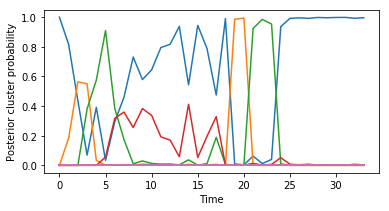

In [13]:
lmda = 10
alfa = 1.0
# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(X_train.flatten()) # this equals 1 if the data are scaled

Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta

r, post, pe, log_lik, log_prior = evaluate(X_train, y_train, Omega, save=False, return_pe=True, split_post=True)
print "Adjusted Rand Index:", r
plt.figure(figsize=(6, 3.0))
plt.plot(post)
plt.gca().set_ylabel('Posterior cluster probability')
plt.gca().set_xlabel('Time')
plt.show()
tf.Session().close()

Segmentation with bag of words is well above chance. Notice that the "fight" events are better recovered than the "poetry" events. This reflects a different degree of structure within them as the fight events mostly reuses two actors.


For comparison, let's compare at the max posterior cluster to the true event labels are shown below (the colors are not consistent between the two due to label switching, which is not important)

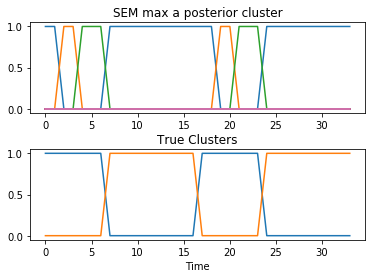

In [14]:
import numpy as np
fig, axes = plt.subplots(2, 1, figsize=(6, 4))

max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')

y_clust = np.zeros((y_train.shape[0], 2))
for ii, y0 in enumerate(y_train):
    y_clust[ii, int(y0)] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()

It's very important that both the prior and the posterior contribute to the clustering process. For this to happen, the scale of the differences between the different hypothesis in terms of log-likelihood and log-prior not be drastically different. For example, if the difference likelihood between two event models is ~100 and the difference between the same two is ~5 in the log-prior than the likelihood will dominate the clustering. 

This scaling can be controled by the $\beta$ parameter, that is, the likehood noise parameter.

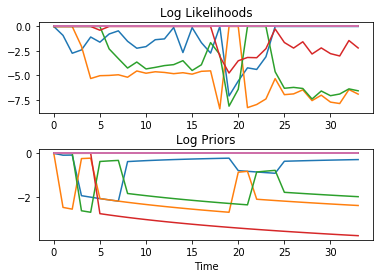

In [15]:
import numpy as np
fig, axes = plt.subplots(2, 1)

axes[0].plot(log_lik)
axes[0].set_title('Log Likelihoods')

axes[1].plot(log_prior)
axes[1].set_title('Log Priors')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()

Mean PE at Event Boundaries:    26.8246651372
Mean PE for all other scences:  19.0292467804
t(24.3) = 3.98; p = 0.000798714


/Users/nickfranklin/anaconda/envs/tensorflow/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


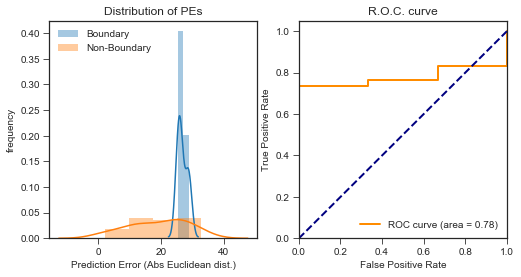

In [16]:
# plot the prediction errors as a function of event boundaries
import seaborn as sns
pe_nonbound = []
pe_bound = []
for ii, y0 in enumerate(y_train[1:], start=1):
    # as an approximation, we consider an event boundary when the event type changes
    if y_train[ii - 1] == y0:
        pe_nonbound.append(pe[ii])
    else:
        pe_bound.append(pe[ii])

        
# Are PEs larger for event boundaries? t-test with unequal variance/sample size:
print "Mean PE at Event Boundaries:   ", np.mean(pe_bound)
print "Mean PE for all other scences: ", np.mean(pe_nonbound)

from scipy.stats import ttest_ind
t, p = ttest_ind(pe_bound, pe_nonbound, equal_var=False)
n1 = len(pe_bound)
n2 = len(pe_nonbound)
s1 = np.var(pe_bound)
s2 = np.var(pe_nonbound)
df = ((s1/n1 + s2/n2)**2) / ( ((s1/n1)**2)/(n1-1)  + ((s2/n2)**2)/(n2-1) )

print "t(%.1f) = %.2f; p = %g" % (df, t, p)
        
# Calculate the R.O.C curve using the PEs to classify event boundaries

# fit a logistic model, boundary ~ PE
import statsmodels.api as sm
X = np.reshape(np.concatenate([pe_bound, pe_nonbound]), (-1, 1))
X = sm.add_constant(X)
y = np.reshape(np.concatenate([np.zeros(len(pe_bound)),
                    np.ones(len(pe_nonbound))]), (-1, 1))
res = sm.Logit(y, X).fit(disp=0)
# Evaluate logistic model with ROC curve
from sklearn.metrics import roc_curve, auc
y_hat = res.predict(X)
fpr, tpr, thr = roc_curve(y, y_hat)
roc_auc = auc(fpr, tpr)

        
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(1, 2, figsize=(8.2, 4), gridspec_kw=dict(wspace=0.2))  
    
    # plot the distribution of prediction errors
    ax = axes[0]
    sns.distplot(pe_bound, ax=ax, label='Boundary')
    sns.distplot(pe_nonbound, ax=ax, label='Non-Boundary')
    ax.legend()
    ax.set_xlabel('Prediction Error (Abs Euclidean dist.)')
    ax.set_ylabel('frequency')
    ax.set_title('Distribution of PEs')

    # plot the ROC curve
    ax = axes[1]
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('R.O.C. curve')
    plt.legend(loc="lower right")
    plt.show()

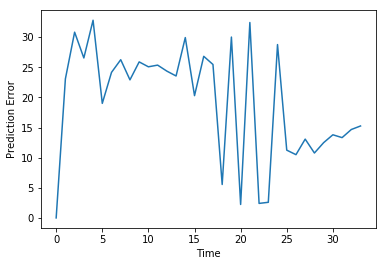

In [17]:
plt.plot(pe)
plt.xlabel('Time')
plt.ylabel('Prediction Error')
plt.show()